<a href="https://colab.research.google.com/github/MarcoMosconi/News-Article-Categorization/blob/main/News_Article_Categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
! pip install transformers
! pip install torch
! pip install scikit-learn
! pip install accelerate -U
! pip install datasets

In [1]:
import os
import pandas as pd
import random
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from datasets import Dataset

In [2]:
df = pd.read_csv("/content/news_article_categorization.csv")
df.head()

,Text,Category
0,"Elon Musk, Amber Heard Something's Fishy On Wr...",Entertainment
1,Scientists are developing more than 100 corona...,science
2,Jared Fogle Shut Down By Judge In Bid for Earl...,Entertainment
3,The agency had come under fire from members of...,Health
4,"Credit...Jim Wilson/The New York TimesJune 30,...",Politics


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3722 entries, 0 to 3721
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      3722 non-null   object
 1   Category  3722 non-null   object
dtypes: object(2)
memory usage: 58.3+ KB


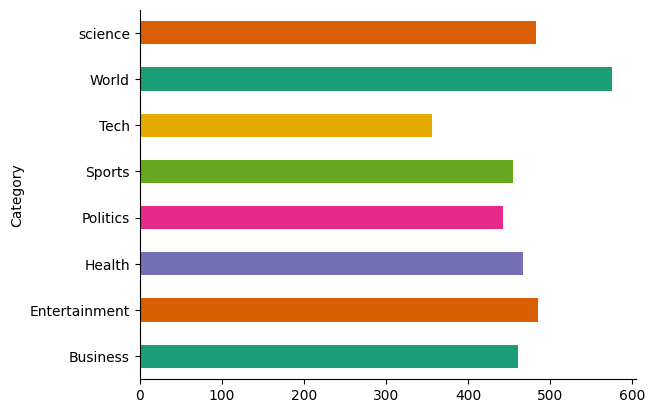

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
count = 0
for i, category in enumerate(df['Category']):
  if category in df['Text'][i:i+1][i].split(' ',1)[0].lower():
    print(category)
    count += 1
print(f'There are {count} articles starting with their category name')
count_science = df['Category'].value_counts().get('science',0)
print(f'There are {count_science} science articles')

science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
There are 92 articles starting with their category name
There are 482 science articles


It's not a bid deal, since just 92 out of 3722 articles start with their category's name. They are all science articles, but it's $\sim \frac15$ of the total, hence we don't think it is necessary to discard the first word ('science'). However, we'll probably obtain a better performance on the science articles  

In [6]:
data = Dataset.from_dict(df)
data

Dataset({
    features: ['Text', 'Category'],
    num_rows: 3722
})

In [7]:
seed = 42
random.seed(seed)

torch.manual_seed(seed)
if torch.cuda.is_available():
  print('true')
  torch.cuda.manual_seed_all(seed)

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
def tokenization(data):
  return tokenizer(data['Text'], padding=True, truncation=True)

tokenized_dataset = data.map(tokenization, batched=True)

Map:   0%|          | 0/3722 [00:00<?, ? examples/s]

In [10]:
tokenized_dataset

Dataset({
    features: ['Text', 'Category', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3722
})

In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
output_dir = './results-bert-news'
os.makedirs(output_dir, exist_ok=True)
logging_dir = './logs'
os.makedirs(logging_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir = output_dir,
    num_train_epochs = 4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=logging_dir,
    eval_strategy='epoch',
    logging_steps=10,
    report_to='tensorboard'
)

In [14]:
def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions)
  acc = accuracy_score(labels, predictions)
  return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [15]:
dataset = tokenized_dataset.train_test_split(test_size=0.2, shuffle=True)
dataset
#train_data, test_data = train_test_split(tokenized_dataset, test_size=0.2, random_state=42, shuffle=True)
#train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=False)

DatasetDict({
    train: Dataset({
        features: ['Text', 'Category', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2977
    })
    test: Dataset({
        features: ['Text', 'Category', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 745
    })
})

In [ ]:
subset_train_dataset = dataset['train'].select(range(1500)) # 1/2 data for time saving

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=subset_train_dataset,
    eval_dataset=dataset['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()

In [ ]:
# def tokenization(text):
#   encoding = tokenizer.batch_encode_plus(
#       text,
#       padding = True,
#       truncation = True,
#       return_tensors = 'pt',
#       add_special_tokens = True
#   )

In [ ]:
# input_ids = encoding['input_ids']
# print(f'Input ID: {input_ids}')
# attention_mask = encoding['attention_mask']
# print(f'Attention mask: {attention_mask}')

Input ID: tensor([[ 101, 3449, 2239,  ...,    0,    0,    0],
        [ 101, 6529, 2024,  ..., 2022, 2550,  102],
        [ 101, 8334, 9666,  ...,    0,    0,    0],
        ...,
        [ 101, 4923, 1012,  ..., 7403, 3891,  102],
        [ 101, 3066, 8654,  ..., 4261, 3867,  102],
        [ 101, 2019, 1044,  ..., 2001, 3020,  102]])
Attention mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


In [ ]:
# label_encoder = LabelEncoder()
# label = label_encoder.fit_transform(df['Category'])
# labels = torch.tensor(label)
# labels

tensor([1, 7, 1,  ..., 2, 0, 2])